In [2]:

import numpy as np
from skimage.color import rgb2gray,rgba2rgb
from skimage.measure import find_contours


from commonfunctions import * 
from skimage.draw import rectangle

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Read Imag and handle its orientation

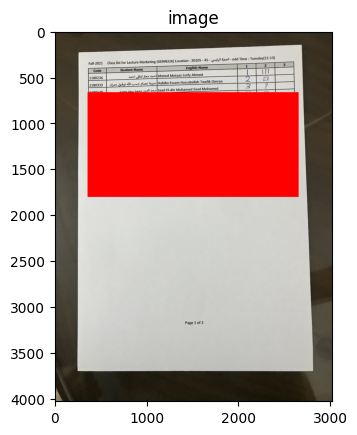

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature, morphology, measure
from skimage.draw import rectangle


def draw_contours(image):
    # Apply Gaussian blur
    blurred = color.rgb2gray(image)
    blurred = feature.canny(blurred, sigma=1)

    # Perform morphological operations to close gaps in edges
    blurred = morphology.closing(blurred, morphology.square(5))

    # Label connected components
    label_image = measure.label(blurred)

    # Find contours using scikit-image
    cnts = measure.find_contours(label_image, 0.5)

    bounding_boxes = list()
    for cnt in cnts:
        min_x = int(round(min(cnt[:,1])))
        max_x = int(round(max(cnt[:,1])))
        min_y = int(round(min(cnt[:,0])))
        max_y = int(round(max(cnt[:,0])))
        if (max_y - min_y) != 0 and (max_x - min_x)/(max_y-min_y) > 2  and (max_x - min_x) > image.shape[0]/2: #  and (max_y-min_y) > image.shape[1]/2:
            bounding_boxes.append([min_x, max_x, min_y, max_y])

    #When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=image.shape)
        image[rr, cc] = [255,0,0] #set color white
    show_images([image],  ['image'])


# Read the image
image = io.imread('grade_sheet/1.jpg')

draw_contours(image)





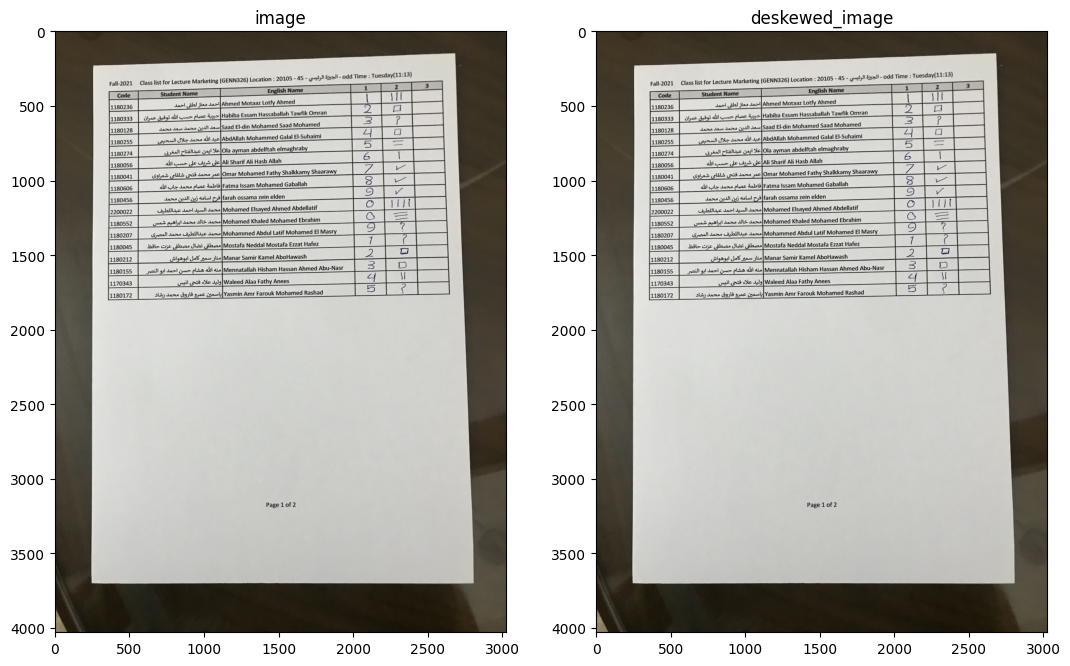

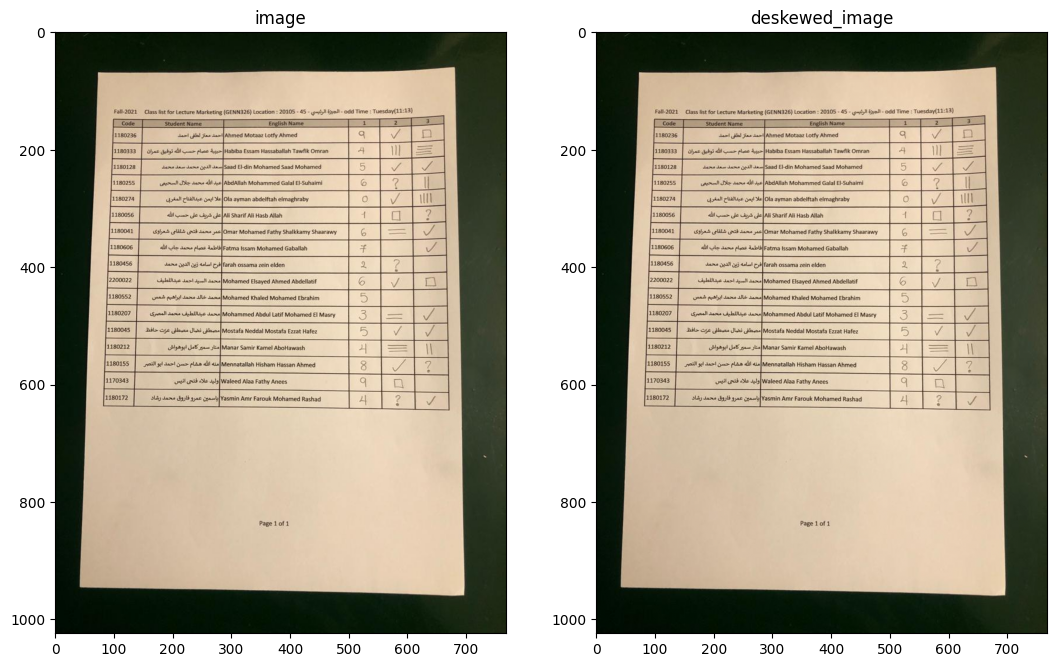

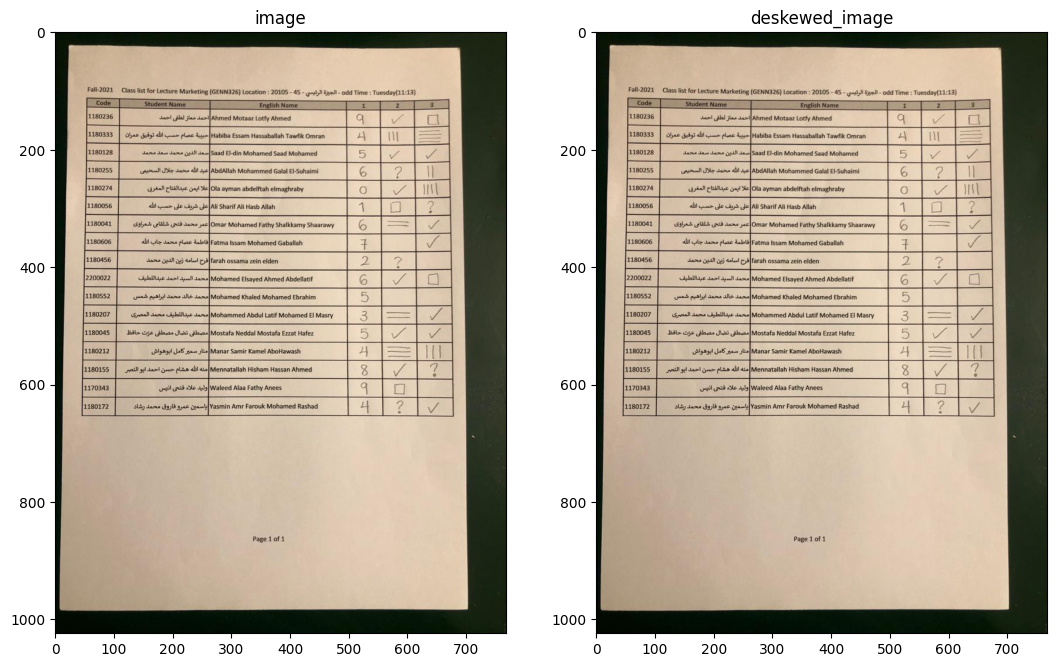

In [4]:
# Read the image 

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature, transform

def deskew_image(img):
    # Read the image
    image = np.copy(img)
    gray = color.rgb2gray(image)

    # Apply edge detection using Canny
    edges = feature.canny(gray, sigma=1.0, low_threshold=0.1, high_threshold=0.9)

    # Use probabilistic Hough Transform to detect lines
    lines = transform.probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)

    # Determine the dominant angle of the lines
    angles = [np.arctan2((y2 - y1), (x2 - x1)) for (x1, y1), (x2, y2) in lines]
    dominant_angle = np.median(angles) * 180 / np.pi

    # Rotate the image to correct skewing and orientation
    rotated_image = transform.rotate(image, dominant_angle, resize=True)

    return rotated_image
# image 4,15 is the only one that is rotated wrong 

deskewed_images = list()

for i in range(1,4):
    image = io.imread('grade_sheet/{}.jpg'.format(i))
    deskewed_image = deskew_image(image)
    show_images([image,deskewed_image], ['image', 'deskewed_image'])
    deskewed_images.append(deskewed_image)
    

## Perspective Transform


[[1268 1345]
 [1428 1737]
 [1756 1623]
 [1683 1519]]


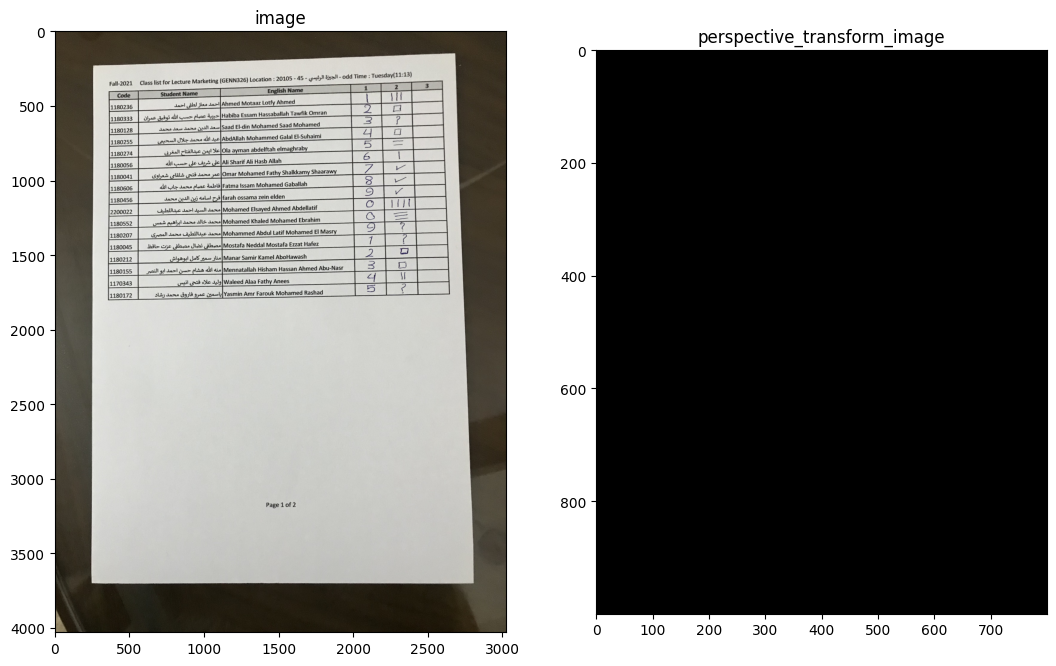

[[479 392]
 [535 291]
 [451 367]
 [507 325]]


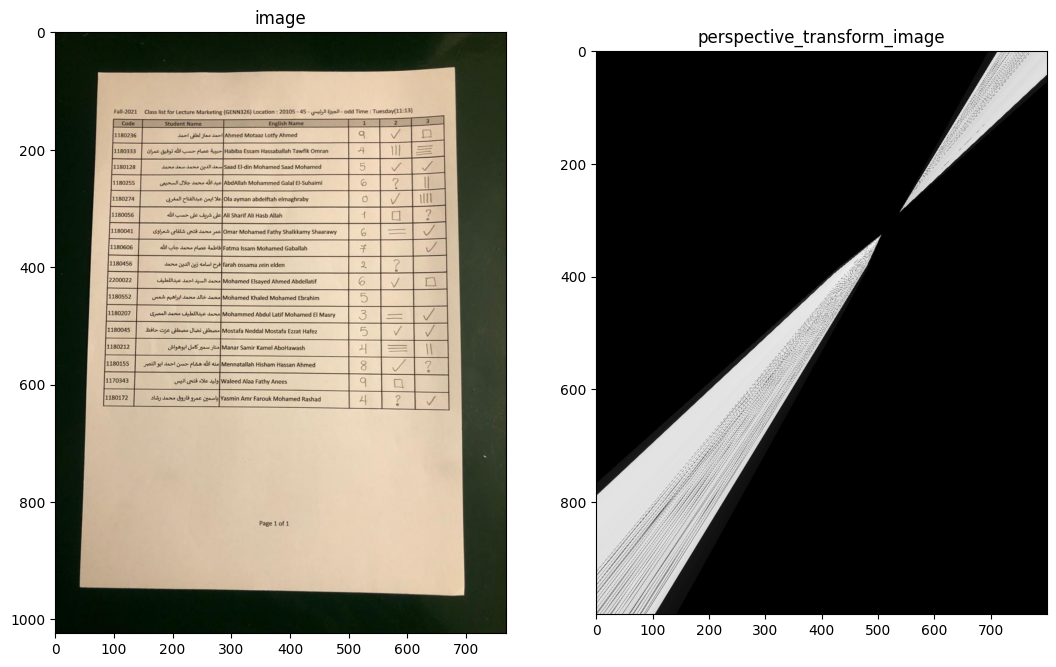

[[480 445]
 [572 265]
 [541 272]
 [418 273]]


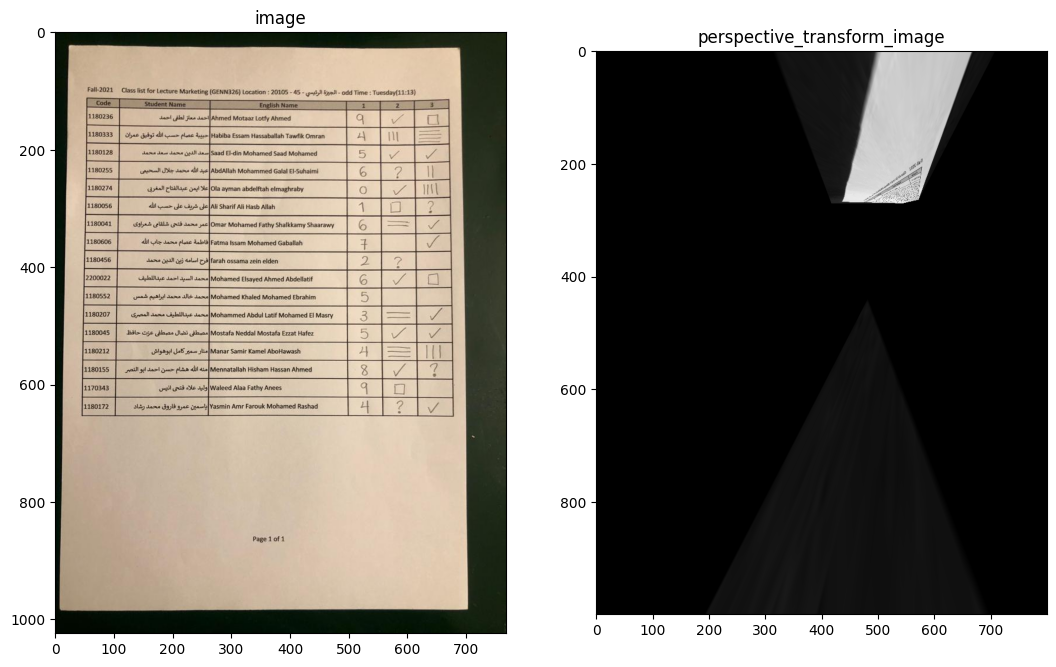

[[470 449]
 [468 273]
 [499 279]
 [560 271]]


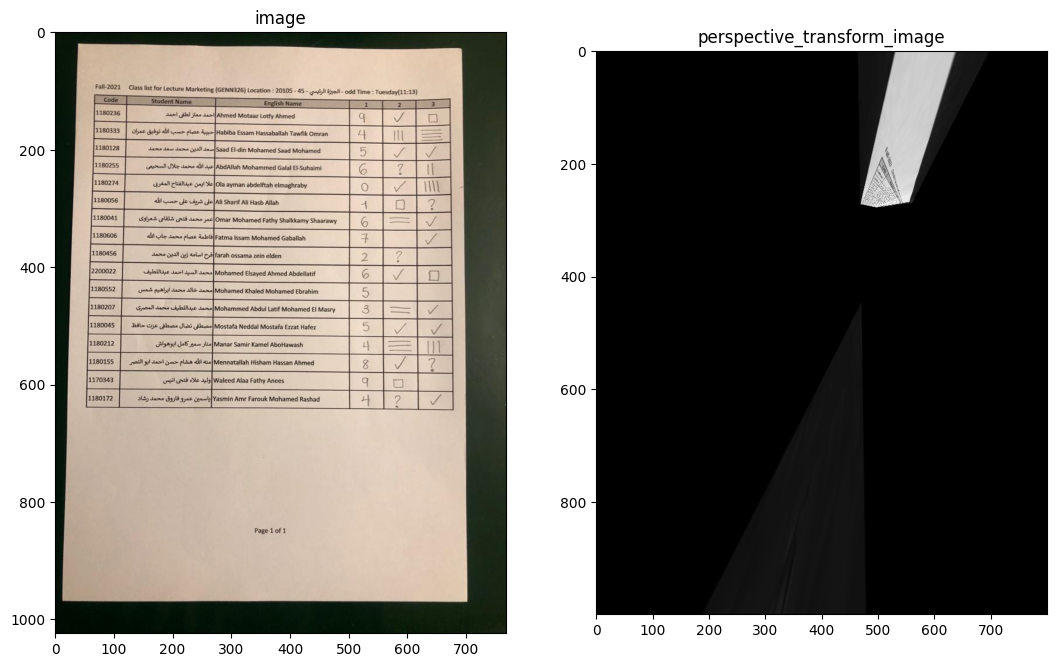

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform
from skimage.feature import corner_harris, corner_peaks

def perspective_transform_image(img, source_points):
    # Read the image
    image = np.copy(img)

    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)

    # Define the destination points (a rectangle)
    destination_points = np.array([[0, 0], [0, 1000], [800, 1000], [800, 0]])

    # Estimate the perspective transform
    tform = transform.ProjectiveTransform()
    tform.estimate(source_points, destination_points)

    # Apply the perspective transformation to the image
    transformed_image = transform.warp(gray_image, tform, output_shape=(1000, 800))

    return transformed_image


for i in range(1,5):
    image = io.imread('grade_sheet/{}.jpg'.format(i))
    # Define the source points (points corresponding to the corners of the sheet)
    corners = corner_peaks(corner_harris(rgb2gray(image)), min_distance=5)
    # Choose the top 4 corners (assuming your sheet has four corners)
    source_points_auto = corners[:4]
    print(source_points_auto)
    show_images([image,perspective_transform_image(image, source_points_auto)], ['image', 'perspective_transform_image'])

## Crop the image

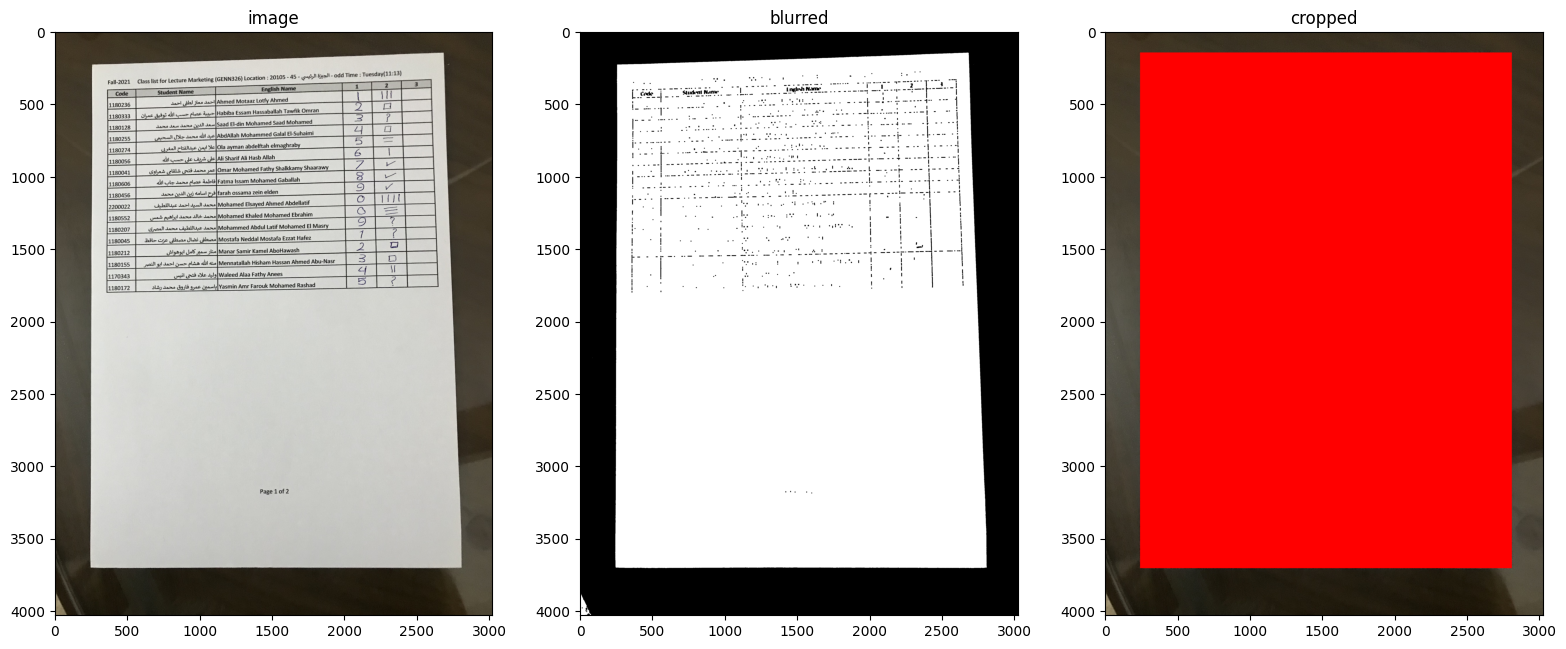

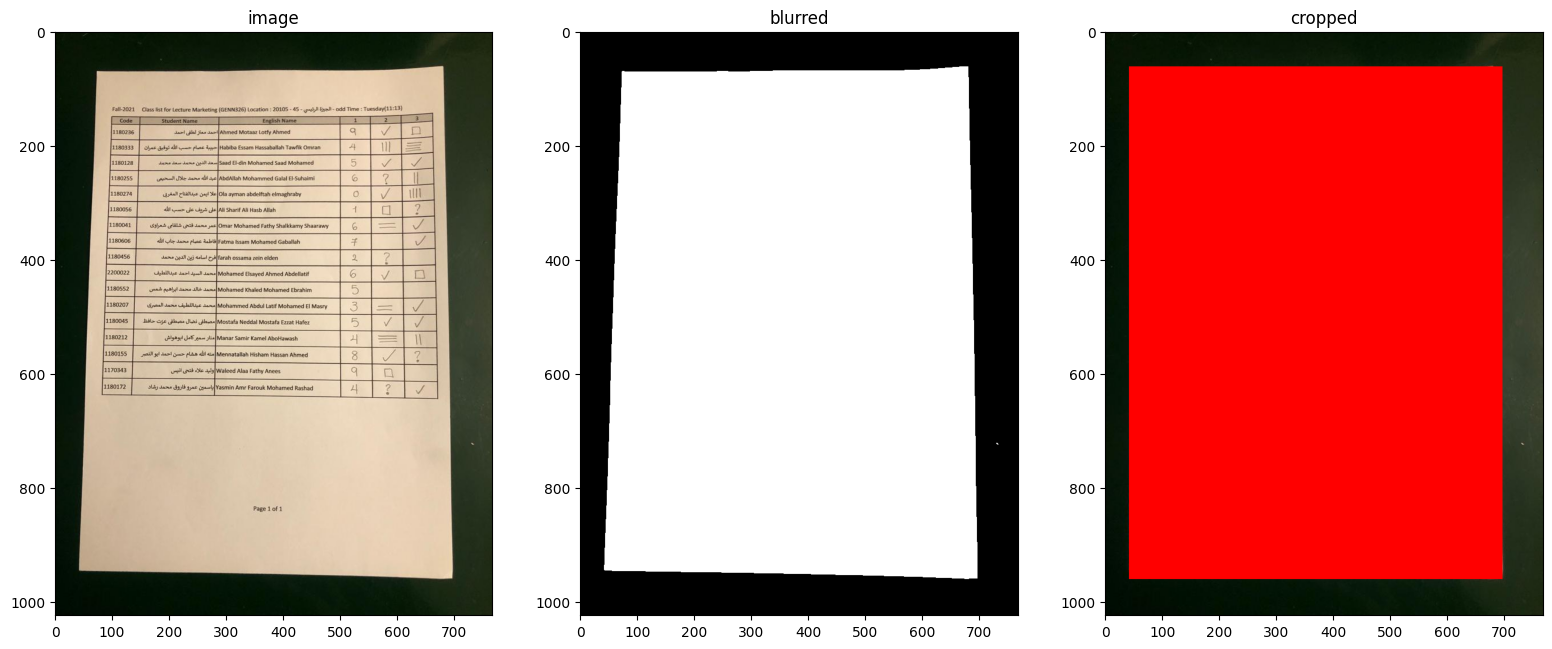

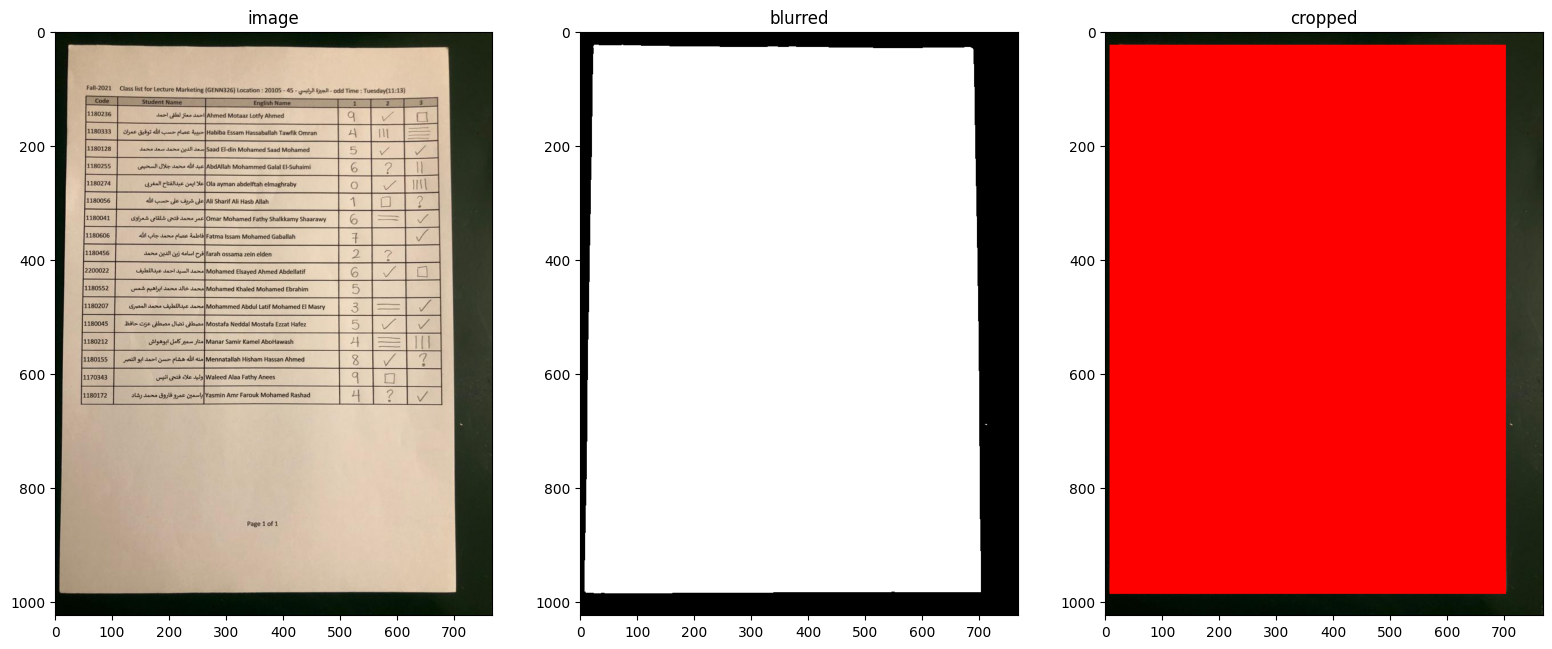

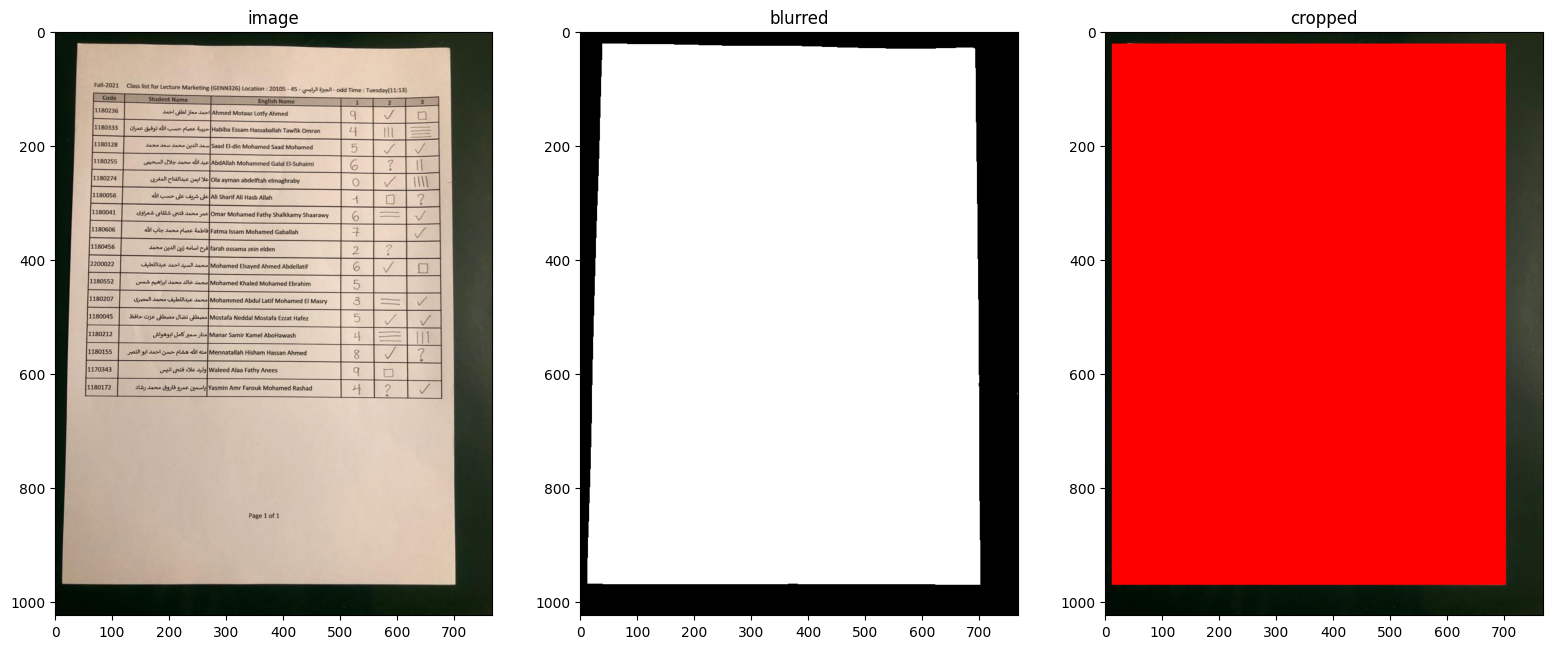

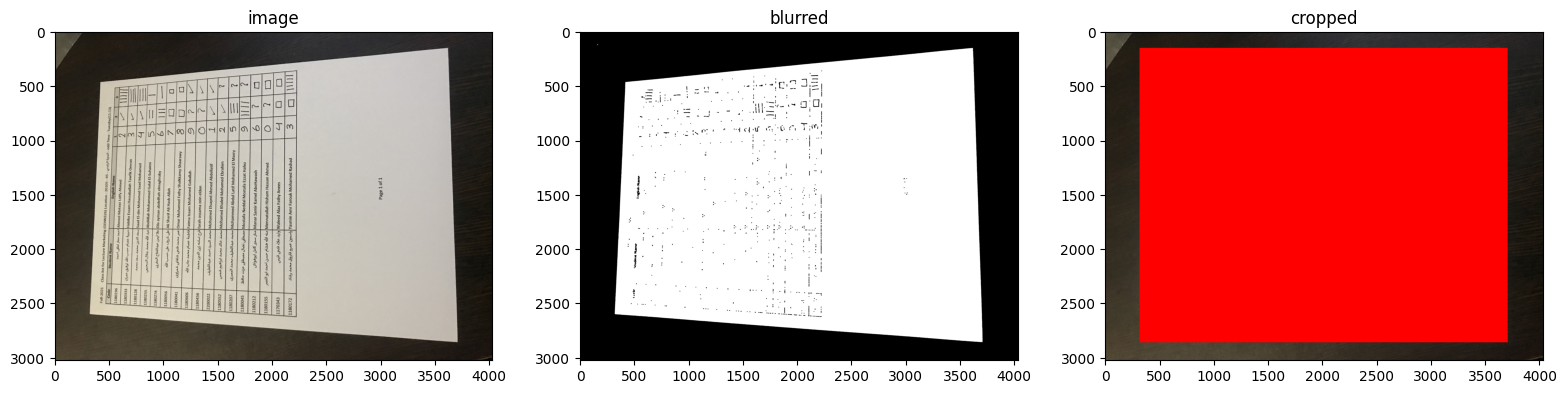

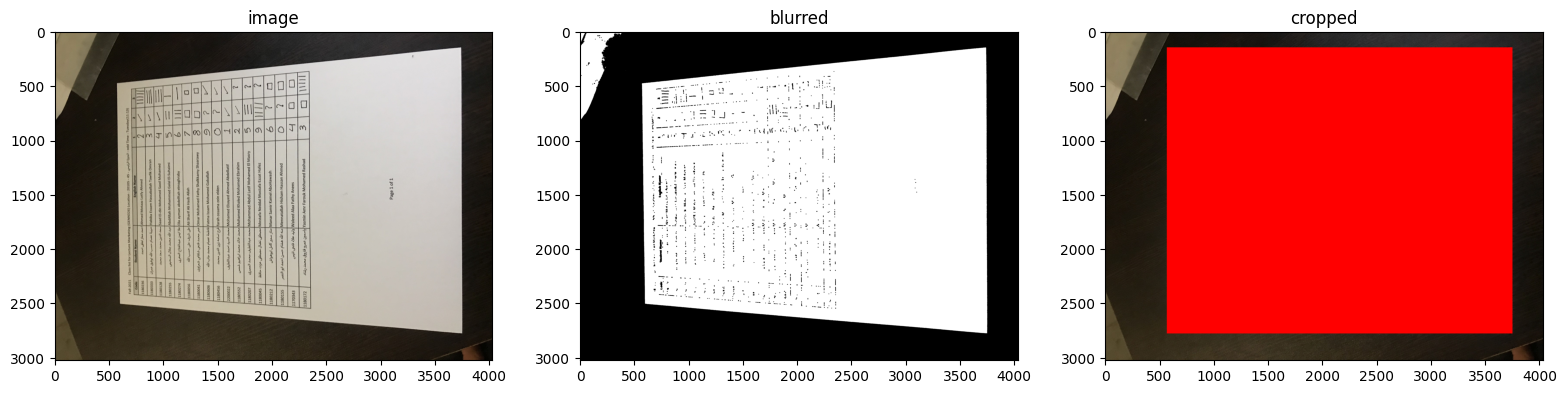

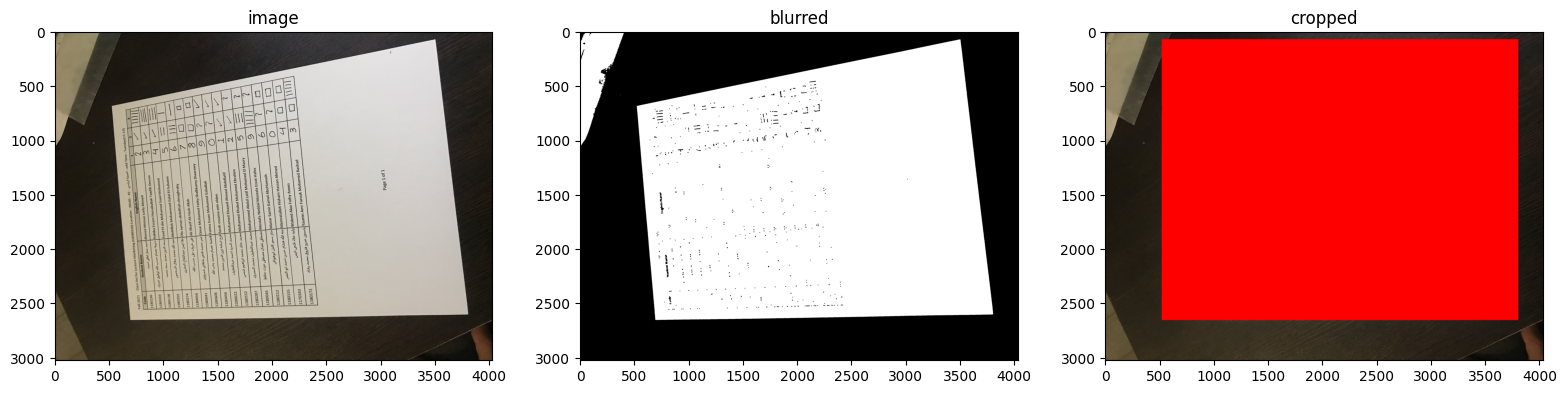

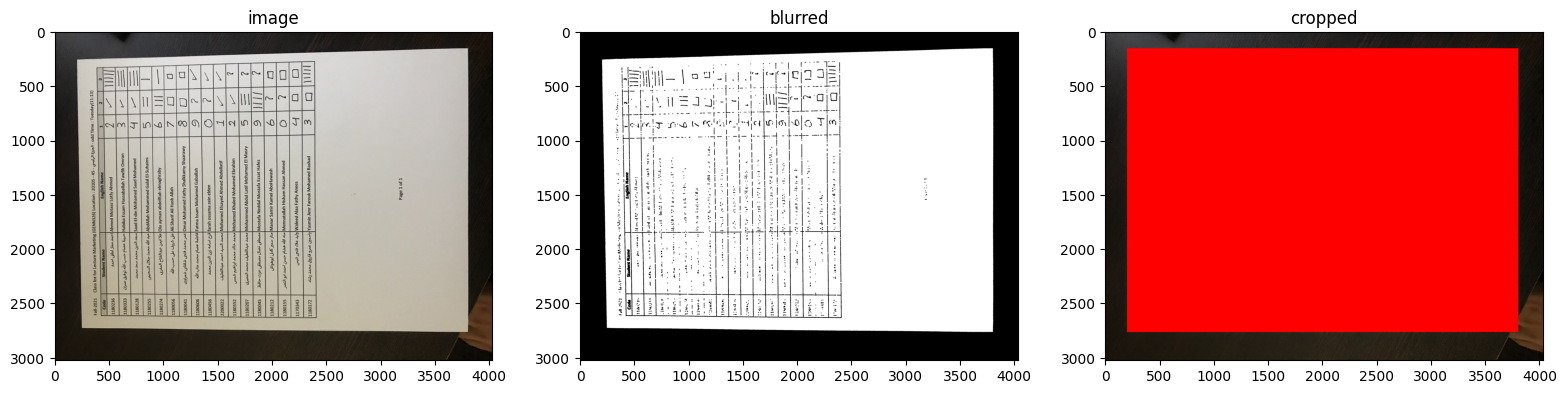

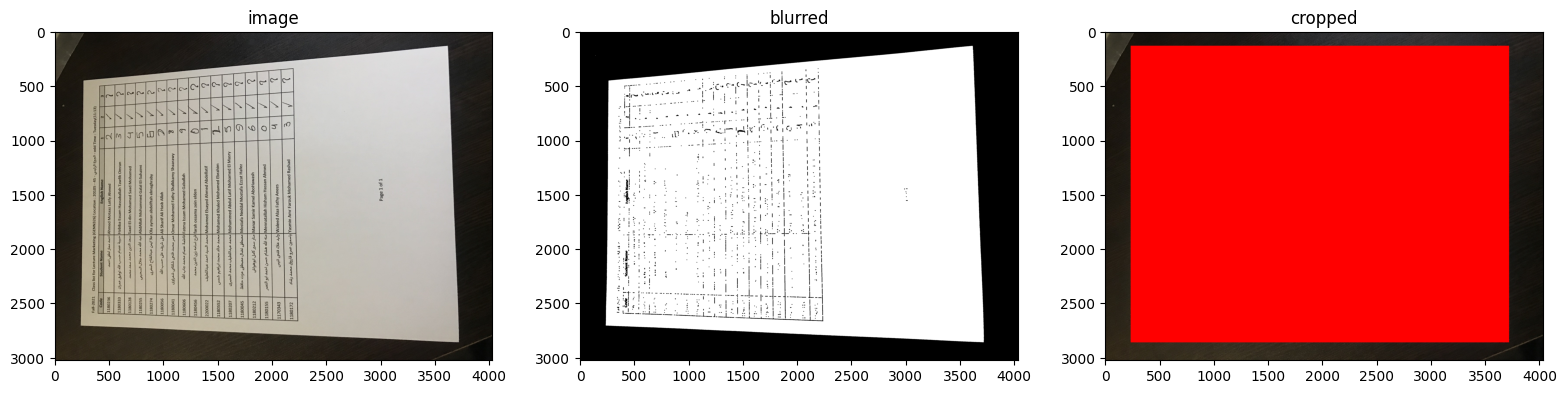

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, morphology, measure, segmentation, filters, draw

def remove_background(img, threshold=0.7):
    # Read the image
    image = np.copy(img)

    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)

    # Threshold the image to identify white regions
    binary_image = gray_image > threshold
    return binary_image
    # # Remove small connected components (noise)
    # binary_image = morphology.remove_small_objects(binary_image, min_size=1000)

    # # Label connected components
    # labeled_image = measure.label(binary_image)

    # # Find the bounding box of the non-blank area
    # region_props = measure.regionprops(labeled_image)
    # minr, minc, maxr, maxc = region_props[0].bbox

    # # Crop the image to the non-blank area
    # cropped_image = image[minr:maxr, minc:maxc]

    # return cropped_image

# Example usage

def segment_sheet(img, num_clusters=2):
    # Read the image
    image = np.copy(img)

    # Convert the image to the LAB color space
    lab_image = color.rgb2lab(image)

    # Flatten the LAB image to a 2D array for k-means clustering
    flat_lab_image = lab_image.reshape((-1, 3))

    # Apply k-means clustering
    kmeans = segmentation.slic(lab_image, n_segments=num_clusters, compactness=10.0, sigma=1.0)
    
    # Identify the segment with the highest mean luminance as the sheet
    luminance_means = [np.mean(lab_image[kmeans == i][:, 0]) for i in range(num_clusters)]
    sheet_segment = np.argmax(luminance_means)

    # Create a mask for the sheet segment
    sheet_mask = (kmeans == sheet_segment)

    # Apply the mask to the original image
    segmented_image = np.copy(image)
    segmented_image[~sheet_mask] = 1

    return segmented_image


def threshold_image(img):
    # Load the image
    image = np.copy(img)

    # Convert to grayscale
    grayscale_image = color.rgb2gray(image)

    # Apply Otsu thresholding
    thresh = filters.threshold_otsu(grayscale_image)
    binary_image = grayscale_image > thresh
    
    # Refine segmentation (optional)

    binary_image = morphology.erosion(binary_image)
    binary_image = morphology.dilation(binary_image)

    # Extract sheet region
    sheet_mask = binary_image.astype(bool)
    sheet = image[sheet_mask]
    
def draw_contours(img):
    # Apply Gaussian blur
    image = np.copy(img)
    
    blurred = color.rgb2gray(image)
    blurred = blurred > .5

    # Perform morphological operations to close gaps in edges
    blurred = morphology.closing(blurred, morphology.square(6))

    # Label connected components (no effect)
    label_image = measure.label(blurred)

    # Find contours using scikit-image
    cnts = measure.find_contours(label_image, .5)

    max_area = 0
    max_box = None
    for cnt in cnts:
        Xmin = int(round(min(cnt[:,1])))
        Xmax = int(round(max(cnt[:,1])))
        Ymin = int(round(min(cnt[:,0])))
        Ymax = int(round(max(cnt[:,0])))

        width = abs( Xmax - Xmin) 
        height = abs(Ymax - Ymin)
        area = width * height 
        
        if area > max_area:
            max_area = area 
            max_box = [Xmin, Xmax, Ymin, Ymax]

    [Xmin, Xmax, Ymin, Ymax] = max_box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=image.shape)
    image[rr, cc] = [255,0,0] #set color white
    return blurred, image



for i in range(1,10):
    image = io.imread('grade_sheet/{}.jpg'.format(i))
    blurred, cropped = draw_contours(image)
    show_images([image,blurred, cropped ], ['image', 'blurred', 'cropped'])
